In [1]:
!pip install pmdarima

In [2]:
!pip install statsmodels

In [3]:
!pip install tqdm

In [4]:
import pandas as pd
import warnings
import numpy as np 
from itertools import product
import matplotlib.pyplot as plt
import datetime as datetime
from datetime import timedelta, date
import seaborn as sns
import matplotlib.cm as CM
%matplotlib inline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
from tqdm.notebook import tqdm
from tqdm.notebook import tqdm_notebook
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX


euro_area = pd.read_csv(r"your_path.csv")

pd.set_option('display.max_columns', None)

euro_area.head(2)

,year,exrate_euro_area,prod_euro_area,unp_euro_area,housep_euro_area,wage_euro_area,Investment_EU
0,1991,1.022,26.3,9.3,83400,19913.19,1679329.30
1,1992,1.022,26.4,8.6,82700,19911.62,1679310.82


In [5]:
# Renaming the columns
euro_area = euro_area.rename(columns={
             'exrate_euro_area': 'Exchange Rate',
             'prod_euro_area': 'Productivity',
             'unp_euro_area': 'Annual Wages',
             'housep_euro_area': 'Housing Prices',
             'wage_euro_area': 'Unemployment',
             'Investment_EU': 'Investment'
})

euro_area.head()

,year,Exchange Rate,Productivity,Annual Wages,Housing Prices,Unemployment,Investment
0,1991,1.022,26.3,9.3,83400,19913.19,1679329.30
1,1992,1.022,26.4,8.6,82700,19911.62,1679310.82
2,1993,1.022,26.3,8.6,81200,19914.77,1679347.78
3,1994,1.023,26.5,9.5,80500,19908.46,1679273.87
4,1995,1.020,26.0,10.6,7900,19921.08,1679421.69


In [6]:
euro_area.set_index('year', inplace=True)
euro_area.head()

,Exchange Rate,Productivity,Annual Wages,Housing Prices,Unemployment,Investment
year,,,,,,
1991,1.022,26.3,9.3,83400,19913.19,1679329.30
1992,1.022,26.4,8.6,82700,19911.62,1679310.82
1993,1.022,26.3,8.6,81200,19914.77,1679347.78
1994,1.023,26.5,9.5,80500,19908.46,1679273.87
1995,1.020,26.0,10.6,7900,19921.08,1679421.69


In [7]:
print(euro_area.columns)

Index(['Exchange Rate', 'Productivity', 'Annual Wages', 'Housing Prices',
       'Unemployment', 'Investment'],
      dtype='object')


#### Note: I have 6 features, and all are time series, which means I can/have to do all the following steps for all of them. However, I only want to forecast the Exchange Rate, thus the following tests will only cover the Exchange Rate feature and I do the loop over temporal divisions only for y.

In [8]:
exchange_rate_df = euro_area[['Exchange Rate']].copy()
exchange_rate_df.head()

,Exchange Rate
year,
1991,1.022
1992,1.022
1993,1.022
1994,1.023
1995,1.020


In [10]:
# x and y creation
y = euro_area.pop("Exchange Rate")
x = euro_area

# List to store cross validation results
cv_results = []

# Define the number of splits for temporal cross validation
n_splits = 3 # or any value you prefer

# Split time series index into 'n_splits' parts
tscv = TimeSeriesSplit(n_splits=n_splits)

# Loop over temporal divisions
for train_index, test_index in tscv.split(y):
     train_series, test_series = y.iloc[train_index], y.iloc[test_index]

### Partial Autocorrelation (PACF) and Autocorrelation (ACF) plots

PACF and ACF are useful tools in time series analysis to identify the presence of autocorrelation patterns in data.

- PACF: measures the correlation between time series values at different lags, removing correlations explained by previous lags. In other words, it shows the direct correlation between the current time series and its lags, excluding intermediate effects by removing the influence of intermediate lags. It is useful for identifying the order of autoregressive (AR) terms in an ARIMA.
- 
ACF: measures the correlation between time series values at different lags, without controlling the effects of intermediate lags. In other words, it shows the direct correlation between an observation and all previous la (determine the number of lags)gs. It is useful for identifying the order of moving average (MA) terms in an ARIMA.

These plots are useful for visualizing the autocorrelation of data and better understanding the temporal structure before proceeding with modeling. They can help identify autocorrelation patterns that can influence model choices and preprocessing techniques.

<Figure size 1200x600 with 0 Axes>

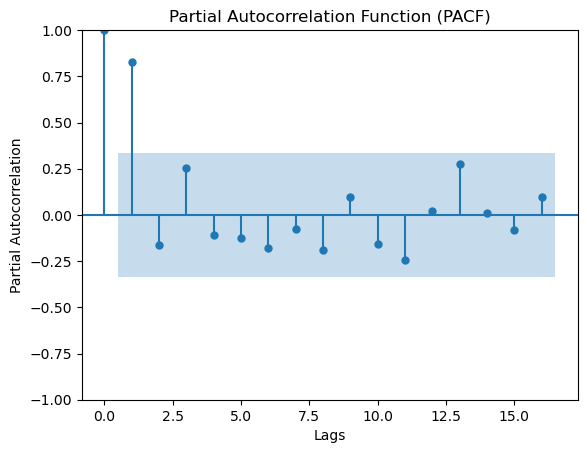

In [11]:
# Plot the partial autocorrelation function - PACF - is the q - is AR
plt.figure(figsize=(12, 6))
plot_pacf(y, lags=16, alpha=0.05)
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

The first two positive values in the PACF suggest that there is a significant autocorrelation up to a lag of order 2, which suggests a possible autoregressive term of order 2 (p = 2)

<Figure size 1200x600 with 0 Axes>

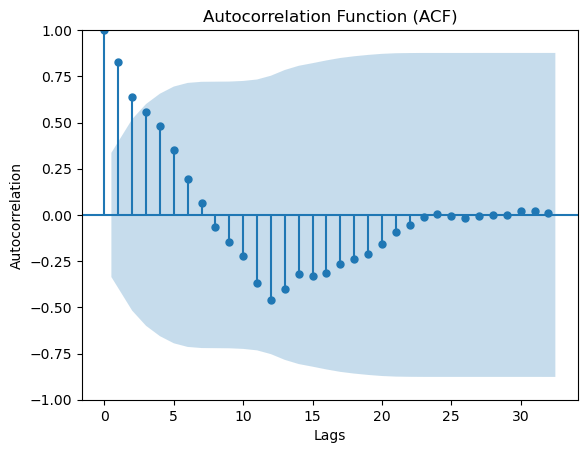

In [12]:
# Plot the autocorrelation function - ACF - is the p - is MA
plt.figure(figsize=(12, 6))
plot_acf(y, lags=32, alpha=0.05)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

### Interpreting the ACF
The ACF gradually decreases, and after 7/8 lags it starts to increase again, and then gradually decreases after 13 lags and stabilizes around 23 lags, this suggests a complex structure, possibly with multiple seasonal patterns or long-term correlations, which can be better modeled by a SARIMA model (Seasonal Autoregressive Integrated Moving Average).

### Augmented Dickey-Fuller (ADF) test - 1

The Augmented Dickey-Fuller (ADF) test is applied to determine whether or not a time series has a unit root, and whether the time series is stationary or not in level. The null hypothesis is that the time series has a unit root, thus it is non-stationary, the alternative hypothesis is that the series is stationary.

A stationary time series is a series in which statistical properties such as mean, variance, and autocovariance are constant over time. A stationary time series is easier to model and predict because its statistical behavior remains consistent over time.

Based on the test statistics, such as the p-value, it is possible to decide whether or not to reject the null hypothesis. If the p-value is less than a pre-determined significance level (usually 0.05), then the null hypothesis is rejected and the time series is concluded to be stationary. Otherwise, if the p-value is greater than the significance level, there is no evidence to reject the null hypothesis, indicating that the time series is non-stationary.

In [13]:
# Perform the Augmented Dickey-Fuller (ADF) test
result_adf = adfuller(train_series)
print('Test statistics:', result_adf[0])
print('p-value:', result_adf[1])
print('Critical values:', result_adf[4])
print('Number of observations:', len(train_series)) 

Test statistics: -1.6693483553751878
p-value: 0.44697026956463914
Critical values: {'1%': -3.7377092158564813, '5%': -2.9922162731481485, '10%': -2.635746736111111}
Number of observations: 26


### Differentiation 

The presence of a unit root showed the need to apply the first difference to generate a stationary series, but I first applied the natural logarithm (base e) to the values since the logarithmic transformation is commonly used to stabilize variance in time series, especially when the series has an exponential trend.

In [14]:
# Apply differentiation (first order)
time_series_diff = np.log(train_series)
time_series_diff = train_series.diff().dropna()

### Augmented Dickey-Fuller (ADF) test - 2

With the features in the first difference, the ADF test is applied again to confirm the stationarity of the series.

In [15]:
# Perform the Augmented Dickey-Fuller (ADF) test again in the differentiated series
result_adf_diff = adfuller(time_series_diff)
print('Test statistics after differentiation:', result_adf_diff[0])
print('P-value after differentiation:', result_adf_diff[1])
print('Critical values after differentiation:', result_adf_diff[4])
print('Number of observations after differentiation:', len(time_series_diff))

Test statistics after differentiation: -4.156330931868981
P-value after differentiation: 0.0007804832089899389
Critical values after differentiation: {'1%': -3.7529275211638033, '5%': -2.998499866852963, '10%': -2.6389669754253307}
Number of observations after differentiation: 25


#### After achieving a stationary series, the PACF and ACF tests are carried out again to find out the suggested values for p and q

In [16]:
# Calculate PACF(q) and ACF(p)

lags = 7 # value provided by the ACF graph
pacf_vals = pacf(time_series_diff, nlags=lags, method='ols')
acf_vals = acf(time_series_diff, nlags=lags)

# Print the PACF values
print("PACF Values:")
print(pacf_vals)

# Print ACF values
print("ACF Values:")
print(acf_vals)

PACF Values:
[ 1.          0.1834208  -0.38623796  0.05241162  0.15914726  0.11352446
 -0.06235     0.06350359]
ACF Values:
[ 1.          0.18183954 -0.31381518 -0.0733857   0.22419588  0.16024385
 -0.11017347 -0.06353213]


In [17]:
def ARIMA_gridsearch(p, d, q, exog):
    results = []
    parameters_list = [(p_val, d_val, q_val) for p_val in p for d_val in d for q_val in q]

    for param in tqdm_notebook(parameters_list):
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                model = ARIMA(train_series, order=param, enforce_invertibility=False, exog=exog)
                model_fit = model.fit()
                
            # Check if the model converged
            if model_fit.mle_retvals['converged']:
                results.append([param, model_fit.aic])
        except:
            continue

    # Create a DataFrame with the results
    if len(results) == 0:
        return None

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,d,q)', 'AIC']

    # Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

p = range(0, 6, 1) # Order of the autoregressive component (AR)
d = [1] # Order of differentiation (D)
q = range(0, 6, 1) # Order of moving average (MA) component

# Perform ARIMA grid search
result_df = ARIMA_gridsearch(p, d, q, exog=None)

# Use automatic template selection methods
auto_model = auto_arima(time_series_diff, seasonal=True, m=12, suppress_warnings=True, max_order=None, stepwise=True)

# Display the best parameters found automatically
print("Best parameters of the ARIMA model:", auto_model.order)

# Adjust the ARIMA model with the new parameters
# model = ARIMA(train_series, order=(p, d, q), exog=x.iloc[train_index]).fit()
# OR
model = ARIMA(train_series, order=(1, 0, 1), exog=None)
model_fit = model.fit()

print(model_fit.summary())

  0%|          | 0/36 [00:00<?, ?it/s]

Best parameters of the ARIMA model: (0, 0, 0)
                               SARIMAX Results                                
Dep. Variable:          Exchange Rate   No. Observations:                   26
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  33.750
Date:                Tue, 09 Apr 2024   AIC                            -59.500
Time:                        20:31:17   BIC                            -54.467
Sample:                             0   HQIC                           -58.050
                                 - 26                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9135      0.081     11.220      0.000       0.754       1.073
ar.L1          0.7479      0.142      5.260      0.000       0.469       1.027
ma.L1 

C:\Users\Helene\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Helene\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Helene\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## Residuals analysis

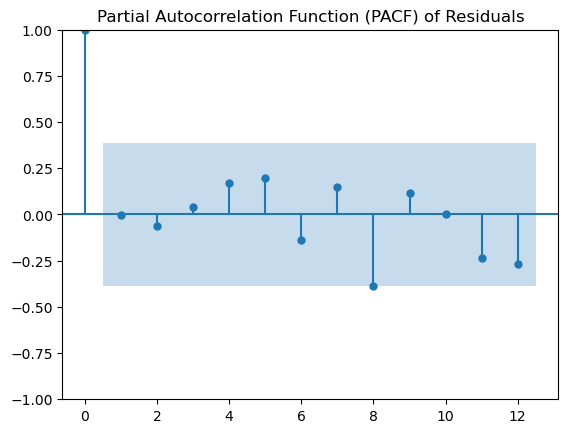

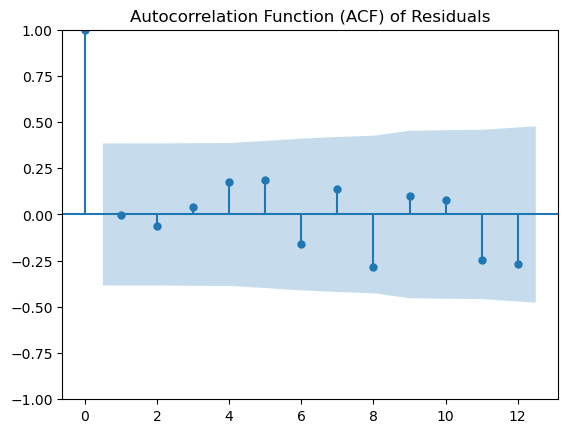

In [18]:
# Extract residuals from the ARIMA model fit
residuals = model_fit.resid

# Plot PACF of residuals
plot_pacf(residuals, lags=12, title='Partial Autocorrelation Function (PACF) of Residuals');

# Plot ACF of residuals
plot_acf(residuals, lags=12, title='Autocorrelation Function (ACF) of Residuals');

C:\Users\Helene\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


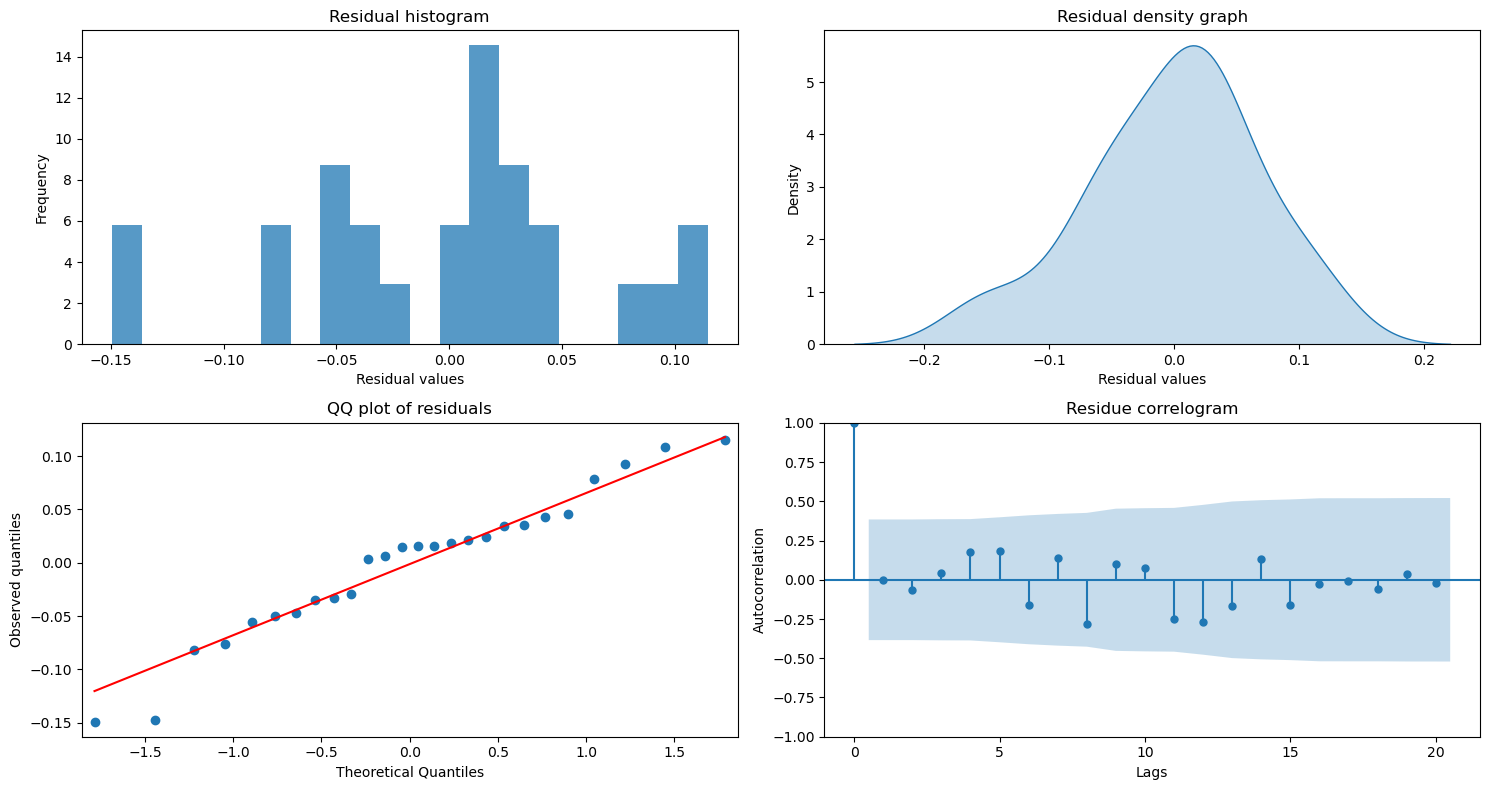

In [19]:
# Residuals diagnosis
fig, ax = plt.subplots(2, 2, figsize=(15, 8))

# Residual histogram
ax[0, 0].hist(model_fit.resid, bins=20, density=True, alpha=0.75)
ax[0, 0].set_title('Residual histogram')
ax[0, 0].set_xlabel('Residual values')
ax[0, 0].set_ylabel('Frequency')

# Residue density graph
sns.kdeplot(model_fit.resid, ax=ax[0, 1], fill=True)
ax[0, 1].set_title('Residual density graph')
ax[0, 1].set_xlabel('Residual values')
ax[0, 1].set_ylabel('Density')

# QQ plot of residuals
sm.qqplot(model_fit.resid, line='s', ax=ax[1, 0])
ax[1, 0].set_title('QQ plot of residuals')
ax[1, 0].set_xlabel('Theoretical Quantiles')
ax[1, 0].set_ylabel('Observed quantiles')

# Residue correlogram
plot_acf(model_fit.resid, ax=ax[1, 1], lags=20)
ax[1, 1].set_title('Residue correlogram')
ax[1, 1].set_xlabel('Lags')
ax[1, 1].set_ylabel('Autocorrelation')

plt.tight_layout()
plt.show()

#### OR

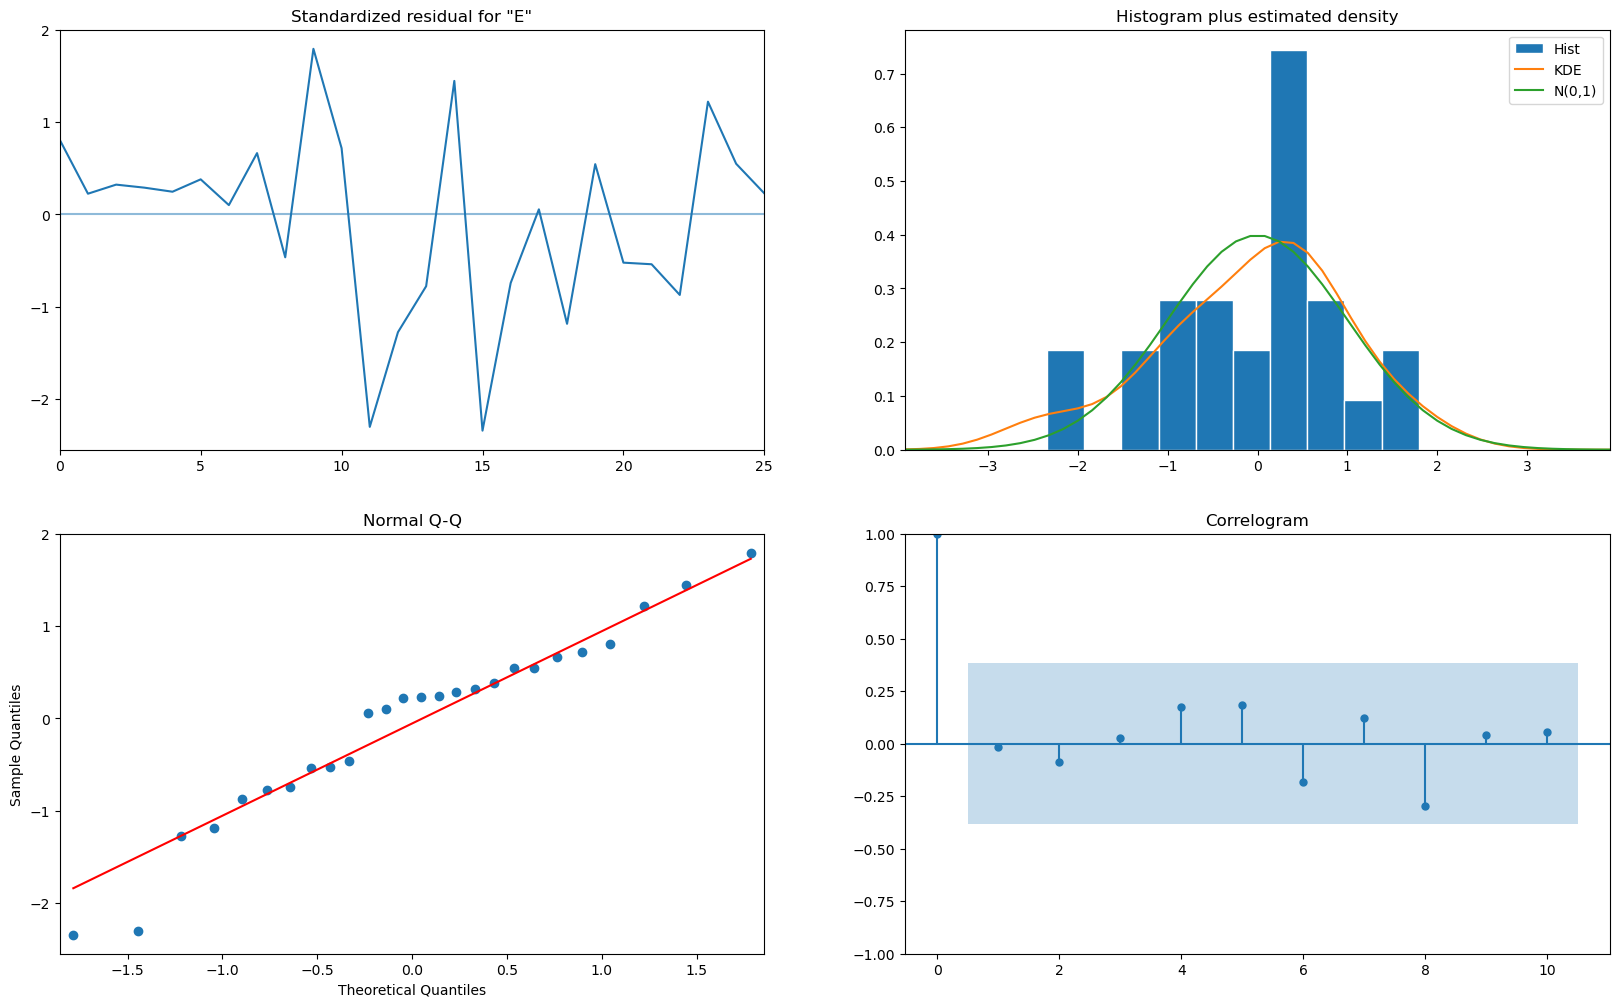

In [20]:
# Residue diagnosis
model_fit.plot_diagnostics(figsize=(20, 12))
plt.show()

### Residual Normality Test

In [21]:
# Shapiro-Wilk test
from scipy.stats import shapiro

residuals_auto = model_fit.resid
stat, p = shapiro(residuals_auto)
print('Test statistic:', stat)
print('p-value:', p)

Test statistic: 0.958868145942688
p-value: 0.3697535991668701


### Residual Homoscedasticity Test

In [22]:
# Breusch-Pagan test
from statsmodels.stats.diagnostic import het_breuschpagan

# Create an array of constants
exog_het = np.column_stack((np.ones(len(residuals_auto)), residuals_auto))

# Run the Breusch-Pagan test
bp_test = het_breuschpagan(residuals_auto, exog_het=exog_het)
print('Breusch-Pagan test statistics:', bp_test[0])
print('Breusch-Pagan test p-value:', bp_test[1])

Breusch-Pagan test statistics: 2.816284042029377
Breusch-Pagan test p-value: 0.09331220158098048


### Forecasting

In [23]:
from statsmodels.tsa.api import ExponentialSmoothing

def rolling_predictions(exchange_rate_df, train_len, horizon, window, period, method):
    TOTAL_LEN = train_len + horizon
    seasonal_steps = int((window / period))
    
    if method == 'mean':
        pred_mean = []
        for i in range(train_len, TOTAL_LEN, window):
            mean = np.mean(exchange_rate_df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        return pred_mean[:horizon]

    elif method == 'last':
        pred_last_value = []
        for i in range(train_len, TOTAL_LEN, window):
            last_value = exchange_rate_df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value[:horizon]
    
    elif method == 'last_season':
        pred_last_season = []
        for i in range(train_len, TOTAL_LEN, window):
            last_season = exchange_rate_df[:i][-period:].values
            pred_last_season.extend(last_season for _ in range(seasonal_steps))
        pred_last_season = np.array(pred_last_season).reshape(1, -1)
        return pred_last_season[0][:horizon]
    
    elif method == 'ARIMA':
        pred_ARIMA = []
        for i in range(train_len, TOTAL_LEN, window):
            model = SARIMAX(exchange_rate_df[:i], order=(1, 0, 1))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean[-window:]
            pred_ARIMA.extend(oos_pred)
        return pred_ARIMA[:horizon]
    
    elif method == 'ES':
        pred_ES = []
        for i in range(train_len, TOTAL_LEN, window):
            model = ExponentialSmoothing(exchange_rate_df[:i], seasonal_periods=window)
            res = model.fit()
            oos_pred = res.forecast(window)
            pred_ES.extend(oos_pred)
        return pred_ES[:horizon]


In [24]:
warnings.filterwarnings("ignore")

# Create an empty DataFrame to store the predictions
pred_df = pd.DataFrame(index=test_series.index)

# Include the 'Exchange Rate' columns from the exchange_rate_df 
pred_df['Exchange Rate'] = exchange_rate_df['Exchange Rate']

TRAIN_LEN = len(train_series)
HORIZON = len(test_series)

windows = [3, 6, 12, 24]

for window in windows:

    pred_mean = rolling_predictions(exchange_rate_df['Exchange Rate'], TRAIN_LEN, HORIZON, window, 3, 'mean')
    pred_last_season = rolling_predictions(exchange_rate_df['Exchange Rate'], TRAIN_LEN, HORIZON, window, 3, 'last_season')
    pred_ARIMA = rolling_predictions(exchange_rate_df['Exchange Rate'], TRAIN_LEN, HORIZON, window, 3, 'ARIMA')
    pred_ES = rolling_predictions(exchange_rate_df['Exchange Rate'], TRAIN_LEN, HORIZON, window, 3, 'ES')
    
    # Create prediction columns in pred_df DataFrame
    pred_df[f'pred_mean_{window}'] = pd.Series(pred_mean, index=test_series.index)
    pred_df[f'pred_last_season_{window}'] = pd.Series(pred_last_season, index=test_series.index)
    pred_df[f'pred_ARIMA_{window}'] = pd.Series(pred_ARIMA, index=test_series.index)
    pred_df[f'pred_ES_{window}'] = pd.Series(pred_ES, index=test_series.index)
    
pred_df.head()

,Exchange Rate,pred_mean_3,pred_last_season_3,pred_ARIMA_3,pred_ES_3,pred_mean_6,pred_last_season_6,pred_ARIMA_6,pred_ES_6,pred_mean_12,pred_last_season_12,pred_ARIMA_12,pred_ES_12,pred_mean_24,pred_last_season_24,pred_ARIMA_24,pred_ES_24
year,,,,,,,,,,,,,,,,,
2017,0.834,0.894769,0.824,0.949467,0.949,0.894769,0.824,0.949467,0.949,0.894769,0.824,0.949467,0.949,0.894769,0.824,0.949467,0.949
2018,0.873,0.894769,0.919,0.945001,0.949,0.894769,0.919,0.945001,0.949,0.894769,0.919,0.945001,0.949,0.894769,0.919,0.945001,0.949
2019,0.890,0.894769,0.949,0.940556,0.949,0.894769,0.949,0.940556,0.949,0.894769,0.949,0.940556,0.949,0.894769,0.949,0.940556,0.949
2020,0.815,0.891759,0.834,0.886314,0.890,0.894769,0.824,0.936132,0.949,0.894769,0.824,0.936132,0.949,0.894769,0.824,0.936132,0.949
2021,0.883,0.891759,0.873,0.882410,0.890,0.894769,0.919,0.931728,0.949,0.894769,0.919,0.931728,0.949,0.894769,0.919,0.931728,0.949


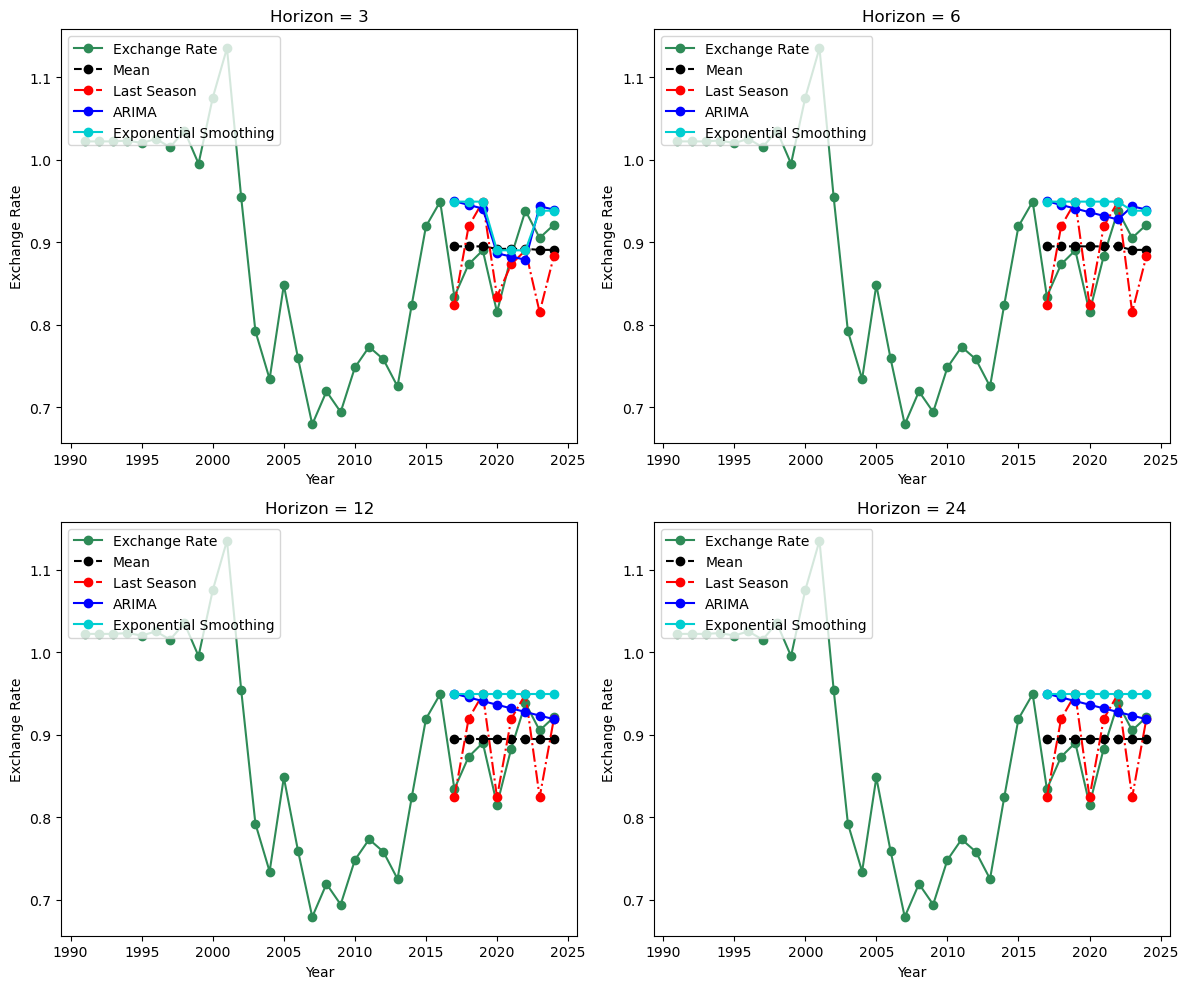

In [25]:
warnings.filterwarnings("ignore")

# Define as janelas
windows = [3, 6, 12, 24]

# Crie uma matriz de subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

for i, ax in enumerate(axes.flatten()):
    
    ax.plot(exchange_rate_df['Exchange Rate'], label='Exchange Rate', color='seagreen', marker='o')
    ax.plot(pred_df[f'pred_mean_{windows[i]}'], label='Mean', color='black', linestyle='--', marker='o')
    ax.plot(pred_df[f'pred_last_season_{windows[i]}'], label='Last Season', color='red', linestyle='-.', marker='o')
    ax.plot(pred_df[f'pred_ARIMA_{windows[i]}'], label='ARIMA', color='blue', marker='o')
    ax.plot(pred_df[f'pred_ES_{windows[i]}'], label='Exponential Smoothing', color='darkturquoise', marker='o')
    
    ax.legend(loc=2)
    ax.set_xlabel('Year')
    ax.set_ylabel('Exchange Rate')
    ax.set_title(f'Horizon = {windows[i]}')
    
plt.tight_layout()
plt.show()

In [26]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

In [27]:
mape_naive_seasonal_3 = mape(pred_df['Exchange Rate'], pred_df['pred_last_season_3'])
mape_ARIMA_3 = mape(pred_df['Exchange Rate'], pred_df['pred_ARIMA_3'])

mape_naive_seasonal_6 = mape(pred_df['Exchange Rate'], pred_df['pred_last_season_6'])
mape_ARIMA_6 = mape(pred_df['Exchange Rate'], pred_df['pred_ARIMA_6'])

mape_naive_seasonal_12 = mape(pred_df['Exchange Rate'], pred_df['pred_last_season_12'])
mape_ARIMA_12 = mape(pred_df['Exchange Rate'], pred_df['pred_ARIMA_12'])

mape_naive_seasonal_24 = mape(pred_df['Exchange Rate'], pred_df['pred_last_season_24'])
mape_ARIMA_24 = mape(pred_df['Exchange Rate'], pred_df['pred_ARIMA_24'])

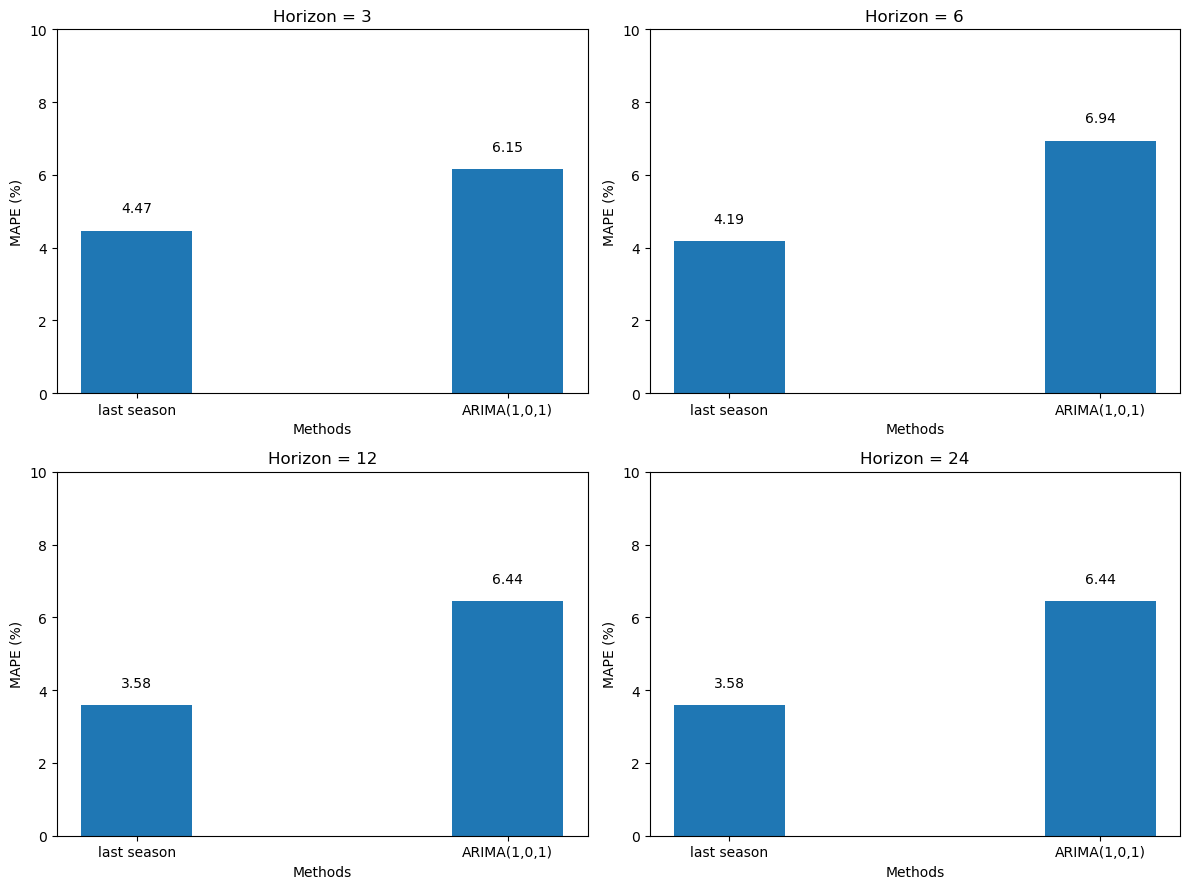

In [28]:
mapes_naive_seasonal = [mape_naive_seasonal_3, mape_naive_seasonal_6, mape_naive_seasonal_12, mape_naive_seasonal_24]
mapes_ARIMA = [mape_ARIMA_3, mape_ARIMA_6, mape_ARIMA_12, mape_ARIMA_24]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

x = ['last season', 'ARIMA(1,0,1)']
width = 0.3

for i, ax in enumerate(axes.flatten()):
    
    y = [mapes_naive_seasonal[i], mapes_ARIMA[i]]
    ax.bar(x, y, width)
    ax.set_xlabel('Methods')
    ax.set_ylabel('MAPE (%)')
    ax.set_ylim(0, 10)
    ax.set_title(f'Horizon = {windows[i]}')    
    
    for index, value in enumerate(y):
        ax.text(x=index, y=value+0.5, s=str(value), ha='center')

plt.tight_layout()
